# Supervised learning leveraging cluster outcomes

## Load the data and import pipeline package 

In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from os import path
from IPython.display import Image
import pipeline
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import sk_models # a script we wrote to run classifiers below + some cleaning functions

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [4]:
#This comes from the output of our clustering analysis
df = pd.read_csv('../process-raw-data/clustered_data.csv')

In [5]:
df.head(1)

,year,SEQN,BMXBMI,BPQ020,RIDAGEYR,RIAGENDR,INDFMPIR,RIDRETH1,TKCAL,TPROT,TCARB,TSUGR,TTFAT,PC1,PC2,PC3,PC4,PC5,PC6,PC7,assignment_kmeans
0,2007-2008,41475,58.04,1,62,2,1.83,5,3057,0.04557,0.11406,0.0525,0.041,-0.950799,3.929718,1.721715,1.414614,1.572015,3.699226,0.415132,1


In [6]:
#Initial exploration
#for col in df.columns:
 #   print(col,": ", type(col))

In [7]:
#Split the data using sklearn's default 80/20
(train, test) = sklearn.model_selection.train_test_split(df)

In [8]:
#Clean the datasets - updated package + included parameters for this dataset
train_1 = train.copy(deep=True)
test_1 = test.copy(deep=True)

clean_train, clean_test = sk_models.clean_split((train_1, test_1))

In [9]:
train.columns

Index(['year', 'SEQN', 'BMXBMI', 'BPQ020', 'RIDAGEYR', 'RIAGENDR', 'INDFMPIR',
       'RIDRETH1', 'TKCAL', 'TPROT', 'TCARB', 'TSUGR', 'TTFAT', 'PC1', 'PC2',
       'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'assignment_kmeans'],
      dtype='object')

In [10]:
clean_train.head(1)

,cluster_1,has_had_hbp,is_obese,RIDAGEYR_scaled,INDFMPIR_scaled,RIAGENDR_1,RIAGENDR_2,RIDRETH1_1,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5
4393,0,1,0,1.435626,0.720418,1,0,0,0,1,0,0


In [11]:
#Checking columns
clean_train.columns

Index(['cluster_1', 'has_had_hbp', 'is_obese', 'RIDAGEYR_scaled',
       'INDFMPIR_scaled', 'RIAGENDR_1', 'RIAGENDR_2', 'RIDRETH1_1',
       'RIDRETH1_2', 'RIDRETH1_3', 'RIDRETH1_4', 'RIDRETH1_5'],
      dtype='object')

In [12]:
#First let's grab BMI (obesity) as the output label - drop the vars and make obese the label

clean_train['label'] = clean_train['is_obese']
clean_train_o = clean_train.drop(['has_had_hbp','is_obese'], axis=1)

clean_test['label'] = clean_test['is_obese']
clean_test_o = clean_test.drop(['has_had_hbp','is_obese'], axis=1)


In [13]:
#Now let's grab blood pressure - drop the vars and make high blood pressure the label

clean_train['label'] = clean_train['has_had_hbp']
clean_train_b = clean_train.drop(['has_had_hbp','is_obese'], axis=1)

clean_test['label'] = clean_test['has_had_hbp']
clean_test_b = clean_test.drop(['has_had_hbp','is_obese'], axis=1)

In [14]:
#col_check
clean_test_b.columns

Index(['cluster_1', 'RIDAGEYR_scaled', 'INDFMPIR_scaled', 'RIAGENDR_1',
       'RIAGENDR_2', 'RIDRETH1_1', 'RIDRETH1_2', 'RIDRETH1_3', 'RIDRETH1_4',
       'RIDRETH1_5', 'label'],
      dtype='object')

In [15]:
#Now let's make dfs leveraging components instead of cluster assignments

clean_train_pca, clean_test_pca = sk_models.clean_split((train, test), components=True)

clean_train_pca['label'] = clean_train_pca['is_obese']
clean_train_o_pca = clean_train_pca.drop(['has_had_hbp','is_obese'], axis=1)

clean_test_pca['label'] = clean_test_pca['is_obese']
clean_test_o_pca = clean_test_pca.drop(['has_had_hbp','is_obese'], axis=1)

In [16]:
#Now let's make dfs leveraging components instead of cluster assignments

clean_train_pca, clean_test_pca = sk_models.clean_split((train, test), components=True)

clean_train_pca['label'] = clean_train_pca['has_had_hbp']
clean_train_b_pca = clean_train_pca.drop(['has_had_hbp','is_obese'], axis=1)

clean_test_pca['label'] = clean_test_pca['has_had_hbp']
clean_test_b_pca = clean_test_pca.drop(['has_had_hbp','is_obese'], axis=1)

## Run models for predicting obesity 

In [17]:
#Define a function to find the best model

def find_best_model(output_list):
    max_o = 0
    best_t = 0
    
    for o in output_list:
        t, accuracy, _ = o
        
        if accuracy > max_o:
            max_o = accuracy
            best_t = t
    
    return best_t, max_o

In [18]:
thresholds = [.5, .6, .7, .8, .9, .95, .99]
rf_o_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_rf_model(clean_train_o, clean_test_o, ['label'], list(clean_train_o.drop(['label'],axis=1).columns),
          t)
    rf_o_outputs.append((t, accuracy, feature_importance))

In [19]:
find_best_model(rf_o_outputs)

(0.95, 0.6393244873341375)

[Text(0, 0, 'RIDRETH1_2'),
 Text(0, 0, 'RIDRETH1_3'),
 Text(0, 0, 'RIAGENDR_2'),
 Text(0, 0, 'RIAGENDR_1'),
 Text(0, 0, 'RIDRETH1_1'),
 Text(0, 0, 'RIDRETH1_4'),
 Text(0, 0, 'RIDRETH1_5'),
 Text(0, 0, 'cluster_1'),
 Text(0, 0, 'RIDAGEYR_scaled'),
 Text(0, 0, 'INDFMPIR_scaled')]

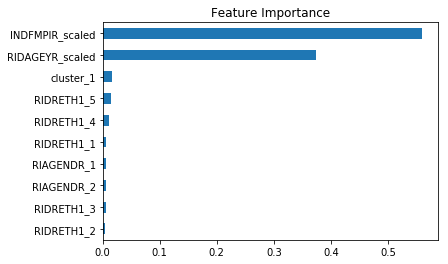

In [20]:
#display feature imporance for best model:
df_1 = rf_o_outputs[5][2].sort_values(by='importance', axis=0, ascending=True)
ax = df_1.plot(kind='barh', legend=False, title='Feature Importance')
ax.set_yticklabels(df_1['feature'])

In [21]:
thresholds = [.5, .6, .7, .8, .9, .95, .99]
svc_o_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_SVC_model(clean_train_o, clean_test_o, ['label'], list(clean_train_o.drop(['label'],axis=1).columns),
          t)
    svc_o_outputs.append((t, accuracy, feature_importance))

In [22]:
find_best_model(svc_o_outputs)

(0.6, 0.6402291917973462)

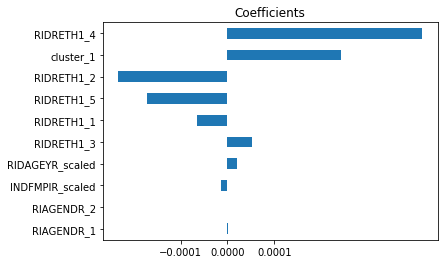

In [23]:
#display feature imporance for best model:
df_2 = svc_o_outputs[0][2]
df_2=df_2.iloc[df_2['value'].abs().argsort()]
ax = df_2.plot(kind='barh', legend=False, title='Coefficients')
ax.set_yticklabels(df_2['coef'])
ax.set_xticks([-.0001,0,.0001])

In [24]:
#Obesity - using PCA factors, rf

rf_o_pca_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_rf_model(clean_train_o_pca, clean_test_o_pca, ['label'], list(clean_train_o_pca.drop(['label'],axis=1).columns),
          t)
    rf_o_pca_outputs.append((t, accuracy, feature_importance))

In [25]:
find_best_model(rf_o_pca_outputs)

(0.8, 0.6444511459589868)

[Text(0, 0, 'RIDRETH1_2'),
 Text(0, 0, 'RIDRETH1_1'),
 Text(0, 0, 'RIAGENDR_2'),
 Text(0, 0, 'RIAGENDR_1'),
 Text(0, 0, 'RIDRETH1_3'),
 Text(0, 0, 'RIDRETH1_5'),
 Text(0, 0, 'RIDRETH1_4'),
 Text(0, 0, 'INDFMPIR_scaled'),
 Text(0, 0, 'RIDAGEYR_scaled'),
 Text(0, 0, 'PC4_scaled'),
 Text(0, 0, 'PC3_scaled'),
 Text(0, 0, 'PC2_scaled'),
 Text(0, 0, 'PC5_scaled'),
 Text(0, 0, 'PC7_scaled'),
 Text(0, 0, 'PC1_scaled'),
 Text(0, 0, 'PC6_scaled')]

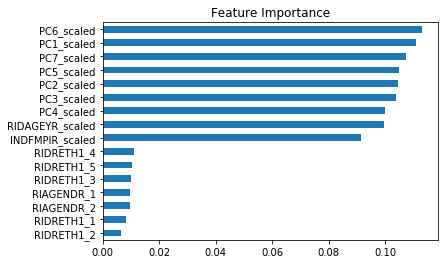

In [26]:
#display feature imporance for best model:
df_3 = rf_o_pca_outputs[3][2].sort_values(by='importance', axis=0, ascending=True)
ax = df_3.plot(kind='barh', legend=False, title='Feature Importance')
ax.set_yticklabels(df_3['feature'])

In [27]:
#Obesity - using PCA factors, SVC
svc_o_pca_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_SVC_model(clean_train_o_pca, clean_test_o_pca, ['label'], list(clean_train_o_pca.drop(['label'],axis=1).columns),
          t)
    svc_o_pca_outputs.append((t, accuracy, feature_importance))

In [28]:
find_best_model(svc_o_pca_outputs)

(0.6, 0.6396260554885405)

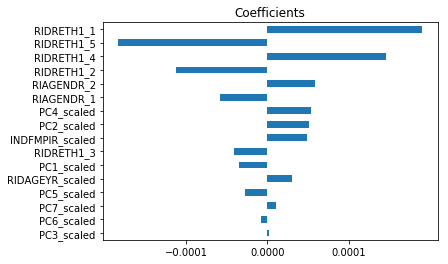

In [29]:
#display feature imporance for best model:
df_4 = svc_o_pca_outputs[1][2]
df_4=df_4.iloc[df_4['value'].abs().argsort()]
ax = df_4.plot(kind='barh', legend=False, title='Coefficients')
ax.set_yticklabels(df_4['coef'])
ax.set_xticks([-.0001,0,.0001])

## Run models for predicting high blood pressure

In [30]:
#Blood pressure - cluster, RF
rf_b_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_rf_model(clean_train_b, clean_test_b, ['label'], list(clean_train_b.drop(['label'],axis=1).columns),
          t)
    rf_b_outputs.append((t, accuracy, feature_importance))

In [31]:
find_best_model(rf_b_outputs)

(0.5, 0.7044632086851629)

[Text(0, 0, 'RIAGENDR_1'),
 Text(0, 0, 'RIDRETH1_5'),
 Text(0, 0, 'RIDRETH1_1'),
 Text(0, 0, 'RIDRETH1_2'),
 Text(0, 0, 'RIAGENDR_2'),
 Text(0, 0, 'RIDRETH1_3'),
 Text(0, 0, 'RIDRETH1_4'),
 Text(0, 0, 'cluster_1'),
 Text(0, 0, 'INDFMPIR_scaled'),
 Text(0, 0, 'RIDAGEYR_scaled')]

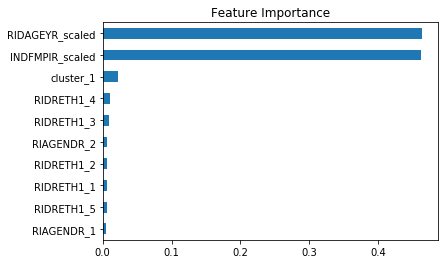

In [32]:
df_5 = rf_b_outputs[0][2].sort_values(by='importance', axis=0, ascending=True)
ax = df_5.plot(kind='barh', legend=False, title='Feature Importance')
ax.set_yticklabels(df_5['feature'])

In [33]:
#Blood pressure - cluster, SVC
svc_b_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_SVC_model(clean_train_b, clean_test_b, ['label'], list(clean_train_b.drop(['label'],axis=1).columns),
          t)
    svc_b_outputs.append((t, accuracy, feature_importance))

In [34]:
find_best_model(svc_b_outputs)

(0.5, 0.7322074788902292)

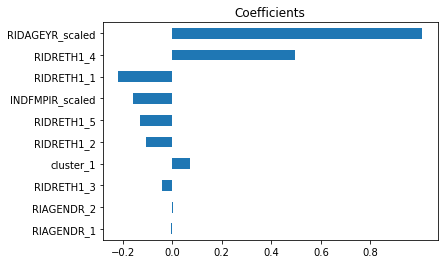

In [35]:
#display feature imporance for best model:
df_6 = svc_b_outputs[0][2]
df_6=df_6.iloc[df_6['value'].abs().argsort()]
ax = df_6.plot(kind='barh', legend=False, title='Coefficients')
ax.set_yticklabels(df_6['coef'])
ax.set_xticks([-.2,0,.2,.4,.6,.8])

In [36]:
#Blood pressure - RF, SVC
rf_b_pca_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_rf_model(clean_train_b_pca, clean_test_b_pca, ['label'], list(clean_train_b_pca.drop(['label'],axis=1).columns),
          t)
    rf_b_pca_outputs.append((t, accuracy, feature_importance))

In [37]:
find_best_model(rf_b_pca_outputs)

(0.5, 0.7029553679131484)

[Text(0, 0, 'RIDRETH1_2'),
 Text(0, 0, 'RIDRETH1_5'),
 Text(0, 0, 'RIDRETH1_1'),
 Text(0, 0, 'RIDRETH1_3'),
 Text(0, 0, 'RIAGENDR_2'),
 Text(0, 0, 'RIDRETH1_4'),
 Text(0, 0, 'RIAGENDR_1'),
 Text(0, 0, 'INDFMPIR_scaled'),
 Text(0, 0, 'PC3_scaled'),
 Text(0, 0, 'PC4_scaled'),
 Text(0, 0, 'PC5_scaled'),
 Text(0, 0, 'PC7_scaled'),
 Text(0, 0, 'PC1_scaled'),
 Text(0, 0, 'PC6_scaled'),
 Text(0, 0, 'PC2_scaled'),
 Text(0, 0, 'RIDAGEYR_scaled')]

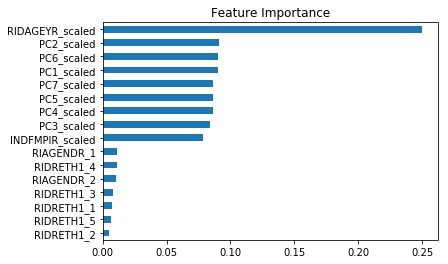

In [38]:
df_7 = rf_b_pca_outputs[0][2].sort_values(by='importance', axis=0, ascending=True)
ax = df_7.plot(kind='barh', legend=False, title='Feature Importance')
ax.set_yticklabels(df_7['feature'])

In [39]:
#Blood pressure - PCA, SVC
svc_b_pca_outputs = []

for t in thresholds:
    accuracy, feature_importance = sk_models.run_SVC_model(clean_train_b_pca, clean_test_b_pca, ['label'], list(clean_train_b_pca.drop(['label'],axis=1).columns),
          t)
    svc_b_pca_outputs.append((t, accuracy, feature_importance))

In [40]:
find_best_model(svc_b_pca_outputs)

(0.5, 0.7276839565741857)

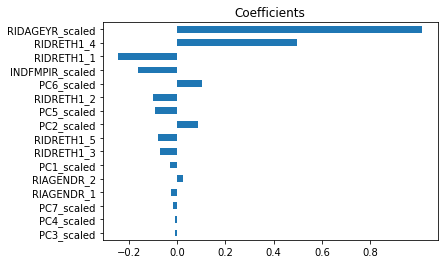

In [41]:
df_8 = svc_b_pca_outputs[0][2]
df_8=df_8.iloc[df_8['value'].abs().argsort()]
ax = df_8.plot(kind='barh', legend=False, title='Coefficients')
ax.set_yticklabels(df_8['coef'])
ax.set_xticks([-.2,0,.2,.4,.6,.8])